# Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()

## Realistic qubit model

In [2]:
def simulate_more_realistic_qubit(
    duration=1, values=np.array([np.pi]), shots=1024, repetitions=1
):

    # 1. Limits for drive amplitudes
    assert np.amax(values) <= 1.0
    assert np.amin(values) >= -1.0
    max_drive_amplitude = 2 * np.pi * 20  # MHz

    # 2. Dephasing error
    dephasing_error = -2 * 2 * np.pi  # MHz

    # 3. Amplitude error
    amplitude_i_error = 0.98
    amplitude_q_error = 1.03

    # 4. Control line bandwidth limit
    cut_off_frequency = 2 * np.pi * 10  # MHz
    resample_segment_count = 1000

    # 5. SPAM error confusion matrix
    confusion_matrix = np.array([[0.99, 0.01], [0.02, 0.98]])

    # Lowering operator
    b = np.array([[0, 1], [0, 0]])
    # Number operator
    n = np.diag([0, 1])
    # Initial state
    initial_state = np.array([[1], [0]])

    with qctrl.create_graph() as graph:
        # Apply 1. max Rabi rate.
        values = values * max_drive_amplitude

        # Apply 3. amplitude errors.
        values_i = np.real(values) * amplitude_i_error
        values_q = np.imag(values) * amplitude_q_error
        values = values_i + 1j * values_q

        # Apply 4. bandwidth limits
        drive_unfiltered = qctrl.operations.pwc_signal(duration=duration, values=values)
        drive_filtered = qctrl.operations.convolve_pwc(
            pwc=drive_unfiltered,
            kernel_integral=qctrl.operations.sinc_integral_function(cut_off_frequency),
        )
        drive = qctrl.operations.discretize_stf(
            drive_filtered, duration=duration, segments_count=resample_segment_count
        )

        # Construct microwave drive
        drive_term = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )

        # Construct 2. dephasing term.
        dephasing_term = qctrl.operations.constant_pwc_operator(
            operator=dephasing_error * n,
            duration=duration,
        )

        # Construct Hamiltonian.
        hamiltonian = qctrl.operations.pwc_sum(
            [
                drive_term,
                dephasing_term,
            ]
        )

        # Solve Schrodinger's equation and get total unitary at the end
        unitary = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )[-1]
        unitary.name = "unitary"

        # Repeat final unitary
        repeated_unitary = np.eye(2)
        for _ in range(repetitions):
            repeated_unitary = repeated_unitary @ unitary
        repeated_unitary.name = "repeated_unitary"

        # Calculate final state.
        state = repeated_unitary @ initial_state

        # Calculate final populations.
        populations = qctrl.operations.abs(state[:, 0]) ** 2
        # Normalize populations
        norm = qctrl.operations.sum(populations)
        populations = populations / norm
        populations.name = "populations"

    # Evaluate graph.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["unitary", "repeated_unitary", "populations"],
    )

    # Extract outputs.
    unitary = result.output["unitary"]["value"]
    repeated_unitary = result.output["repeated_unitary"]["value"]
    populations = result.output["populations"]["value"]

    # Sample projective measurements.
    true_measurements = np.random.choice(2, size=shots, p=populations)
    measurements = np.array(
        [np.random.choice(2, p=confusion_matrix[m]) for m in true_measurements]
    )

    results = {"unitary": unitary, "measurements": measurements}

    return results

## Default pulse parameters and simulation

In [14]:
max_rabi_rate = 20 * 2 * np.pi  # MHz
not_duration  = np.pi / (max_rabi_rate)  # us
h_duration    = np.pi / (2 * max_rabi_rate)  # us
shots         = 1024
values        = np.array([1.0])

In [15]:
not_results = simulate_more_realistic_qubit(
    duration=not_duration, values=values, shots=shots
)

h_results = simulate_more_realistic_qubit(
    duration=h_duration, values=values, shots=shots
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


## Results comparison

In [17]:
error_norm = (
    lambda operate_a, operator_b: 1
    - np.abs(np.trace((operate_a.conj().T @ operator_b)) / 2) ** 2
)

def estimate_probability_of_one(measurements):
    size = len(measurements)
    probability = np.mean(measurements)
    standard_error = np.std(measurements) / np.sqrt(size)
    return (probability, standard_error)

In [20]:
realised_not_gate = not_results["unitary"]
ideal_not_gate    = np.array([[0, -1j], [-1j, 0]])
not_error         = error_norm(realised_not_gate, ideal_not_gate)

realised_h_gate   = h_results["unitary"]
ideal_h_gate      = (1 / np.sqrt(2)) * np.array([[1, -1j], [-1j, 1]])
h_error           = error_norm(realised_h_gate, ideal_h_gate)

not_measurements = not_results["measurements"]
h_measurements   = h_results["measurements"]

not_probability, not_standard_error = estimate_probability_of_one(not_measurements)
h_probability, h_standard_error = estimate_probability_of_one(h_measurements)

print("Realised NOT Gate:")
print(realised_not_gate)
print("Ideal NOT Gate:")
print(ideal_not_gate)
print("NOT Gate Error:" + str(not_error))
print(" ")
print("NOT estimated probability of getting 1:" + str(not_probability))
print("NOT estimate standard error:" + str(not_standard_error) + "\n")
print(" ")
print("Realised H Gate:")
print(realised_h_gate)
print("Ideal H Gate:")
print(ideal_h_gate)
print("H Gate Error:" + str(h_error))
print(" ")
print("H estimated probability of getting 1:" + str(h_probability))
print("H estimate standard error:" + str(h_standard_error))

Realised NOT Gate:
[[0.75412104-0.02524955j 0.1026601 -0.64817036j]
 [0.1026601 -0.64817036j 0.70940919+0.25704996j]]
Ideal NOT Gate:
[[ 0.+0.j -0.-1.j]
 [-0.-1.j  0.+0.j]]
NOT Gate Error:0.5693360860922008
 
NOT estimated probability of getting 1:0.4443359375
NOT estimate standard error:0.015527870361227077

 
Realised H Gate:
[[0.98219782-0.00092913j 0.01473832-0.18726817j]
 [0.01473832-0.18726817j 0.96995998+0.15456728j]]
Ideal H Gate:
[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]
H Gate Error:0.31912041750757547
 
H estimated probability of getting 1:0.0478515625
H estimate standard error:0.006670377500730711


# Trying some control...

The results above are not good. We now look to the Optimize Controls notebook to try and get a pulse that better approaches the ideal NOT and H gates using the realistic qubit model.

# ----- Cloud Qubit -----

Nothing changed here yet, this is just the code from the QCHack main notebook.

In [21]:
control_count = 5
segment_count = 16
duration = 30.0
shot_count = 32

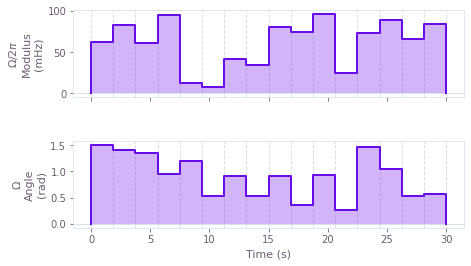

In [24]:
controls = []
for k in range(control_count):
    # Create a random string of complex numbers for each controls.
    real_part = np.random.random(size=[segment_count])
    imag_part = np.random.random(size=[segment_count])
    values = 0.15 * k * (real_part + 1j * imag_part)

    controls.append({"duration": duration, "values": values})

# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count, "value": value} for value in values
        ]
    },
)

In [25]:
# Obtain the results of the experiment.
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.


In [26]:
measurements = experiment_results.measurements
for k, measurement_counts in enumerate(measurements):
    print(f"control #{k}: {measurement_counts}")

control #0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
control #1: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
control #2: [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1]
control #3: [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]
control #4: [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


In [41]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

control #0: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
control #1: P(|0>) = 0.75, P(|1>) = 0.25, P(|2>) = 0.00
control #2: P(|0>) = 0.53, P(|1>) = 0.47, P(|2>) = 0.00
control #3: P(|0>) = 0.34, P(|1>) = 0.66, P(|2>) = 0.00
control #4: P(|0>) = 0.59, P(|1>) = 0.41, P(|2>) = 0.00


In [27]:
repetitions = [1, 4, 16, 32, 64]

controls = []
# Create a random string of complex numbers for all control,
# but set a different repetition_count for each control.
real_part = np.random.random(size=[segment_count])
imag_part = np.random.random(size=[segment_count])
values = 0.5 * (real_part + 1j * imag_part)

for repetition_count in repetitions:
    controls.append(
        {"duration": duration, "values": values, "repetition_count": repetition_count}
    )

experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

for repetition_count, measurement_counts in zip(
    repetitions, experiment_results.measurements
):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(
        f"With {repetition_count:2d} repetitions: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.
With  1 repetitions: P(|0>) = 0.47, P(|1>) = 0.53, P(|2>) = 0.00
With  4 repetitions: P(|0>) = 0.50, P(|1>) = 0.50, P(|2>) = 0.00
With 16 repetitions: P(|0>) = 0.50, P(|1>) = 0.50, P(|2>) = 0.00
With 32 repetitions: P(|0>) = 0.97, P(|1>) = 0.03, P(|2>) = 0.00
With 64 repetitions: P(|0>) = 0.91, P(|1>) = 0.09, P(|2>) = 0.00
